# Object Detection with SSD
Single Shot MultiBox Detector (SSD) (https://arxiv.org/abs/1512.02325) is designed for object detection in realtime. It works with standard datasets such as [PascalVOC](http://host.robots.ox.ac.uk/pascal/VOC/) and [COCO](https://cocodataset.org/#home). In this playground we use a pre-trained SSD model and do some inference and evaluation on COCO dataset. 

Note: Fireball uses the [OpenCV python package](https://pypi.org/project/opencv-python/) to process images in the ImageNet dataset. We also use the [matplotlib](https://matplotlib.org) package in this notebook to display images.

## Create a COCO dataset
Let's first load the COCO dataset and review dataset statistics.

**Note:** If the COCO dataset is not available on this machine, the following code can take a long time when it is executed for the first time as the dataset needs to be downloaded and intialized. Please be patient and avoid interrupting the process during the download.

In [3]:
import numpy as np
import time, os
from fireball import Model, myPrint
from fireball.datasets.coco import CocoDSet

gpus = "0,1,2,3"

# Preparing the dataset and model (Downloading them if necessary)
CocoDSet.download()
Model.downloadFromZoo("SSD512.fbm", "./Models/")

myPrint('\nPreparing Coco dataset ... ', False)
trainDs,testDs = CocoDSet.makeDatasets('Train,Test', batchSize=128, resolution=512, keepAr=False, numWorkers=4)
trainDs.batchSize = 64
myPrint('Done.')
CocoDSet.printDsInfo(trainDs, testDs)
CocoDSet.printStats(trainDs, testDs)


Creating folder "./Models/" ...
  Success!

Preparing Coco dataset ... Done.
CocoDSet Dataset Info:
    Number of Classes .............................. 81
    Dataset Location ............................... /home/shahab/data/mscoco/
    Number of Training Samples ..................... 82783
    Number of Test Samples ......................... 5000
    Sample Shape ................................... (512, 512, 3)

    Dataset Statistics:
    +--------------------+--------------------+--------------------+
    | Class              |       Train        |        Test        |
    |                    | Objects    Images  | Objects    Images  |
    +--------------------+--------------------+--------------------+
    |   0 background     | 0          0       | 0          0       |
    |   1 person         | 185315     45174   | 11004      2693    |
    |   2 bicycle        | 4955       2287    | 316        149     |
    |   3 car            | 30785      8606    | 1932       535     |
    

## Create an SSD Fireball model and print the model information
Let's load the model information from a pre-trained fireball model and print information about different layers of the model. 

For your information, the SSD's layer info is as follows. Since we already have a trained fbm file for SSD, we don't use this information in the code.

```
layersInfo = ('IMG_S512_D3;' +                                                      # Input Layer  |
              'CONV_K3_O64_Ps:ReLu,CONV_K3_O64_Ps:ReLu:MP_K2_Ps;' +                 # block 1      |
              'CONV_K3_O128_Ps:ReLu,CONV_K3_O128_Ps:ReLu:MP_K2_Ps;' +               # block 2      |
              '2*CONV_K3_O256_Ps:ReLu,CONV_K3_O256_Ps:ReLu:MP_K2_Ps;' +             # block 3      |> VGG-16
              '2*CONV_K3_O512_Ps:ReLu,CONV_K3_O512_Ps:ReLu:FM_A4_N2:MP_K2_Ps;' +    # block 4  FM1 |
              '2*CONV_K3_O512_Ps:ReLu,CONV_K3_O512_Ps:ReLu:MP_K3_S1_Ps;' +          # block 5      |
              'CONV_K3_D6_O1024_Ps:ReLu,CONV_K1_O1024_Ps:ReLu:FM_A6;' +             # block 6  FM2 |

              'CONV_K1_O256_Ps:ReLu,CONV_K3_S2_O512_Ps:ReLu:FM_A6;' +               # block 7  FM3 |
              'CONV_K1_O128_Ps:ReLu,CONV_K3_S2_O256_Ps:ReLu:FM_A6;' +               # block 8  FM4 |
              'CONV_K1_O128_Ps:ReLu,CONV_K3_S2_O256_Ps:ReLu:FM_A6;' +               # block 9  FM5 |
              'CONV_K1_O128_Ps:ReLu,CONV_K3_S2_O256_Ps:ReLu:FM_A4;' +               # block 10 FM6 |> SSD
              'CONV_K1_O128_Ps:ReLu,CONV_K2_S2_O256_Ps:ReLu:FM_A4;' +               # block 11 FM7 |
              'AFM_C81;' +                                                # Aggregate Feature Maps |
              'OBJECT')                                                             # Output Layer |                                                         
```

In [4]:
Model.config.maxDetectionsPerImage = 20
Model.config.maxDetectionPerClass = 20
Model.config.scoreThreshold = 0.5

model = Model.makeFromFile("Models/SSD512.fbm", testDs=testDs, gpus=gpus)
model.printLayersInfo()
model.initSession()


Reading from "Models/SSD512.fbm" ... Done.
Creating the fireball model "SSD512" ... Done.

Scope            InShape       Comments                 OutShape      Activ.   Post Act.        # of Params
---------------  ------------  -----------------------  ------------  -------  ---------------  -----------
IN_IMG                         Image Size: 512x512x3    512 512 3     None                      0          
S1_L1_CONV       512 512 3     KSP: 3 1 s               512 512 64    ReLU                      1,792      
S1_L2_CONV       512 512 64    KSP: 3 1 s               256 256 64    ReLU     MP(KSP):2 2 s    36,928     
S2_L1_CONV       256 256 64    KSP: 3 1 s               256 256 128   ReLU                      73,856     
S2_L2_CONV       256 256 128   KSP: 3 1 s               128 128 128   ReLU     MP(KSP):2 2 s    147,584    
S3_L1_CONV       128 128 128   KSP: 3 1 s               128 128 256   ReLU                      295,168    
S3_L2_CONV       128 128 256   KSP: 3 1 s   

## A quick inference demo
Now let's show how this model can be used to detect objects in an image. Here we are using a JPEG image with a bunch of apples, oranges, and bananas.

We scale the image to 512x512 using the [scaleImageAndBoxes](https://interdigitalinc.github.io/Fireball/html/source/datasets.html#fireball.datasets.coco.CocoDSet.scaleImageAndBoxes) function, normalize the image pixel values, and then call the [inferOne](https://interdigitalinc.github.io/Fireball/html/source/model.html#fireball.model.Model.inferOne) function passing the scaled, normalized image. This function returns the detected object information which includes object labels and their bounding boxes.

Number of detected objects: 17
    0: orange (99%) at [0.7677024  0.6904564  0.9764442  0.95904315]
    1: orange (99%) at [0.79598737 0.4396059  0.9780544  0.7210949 ]
    2: banana (98%) at [0.4662459  0.40474463 0.78895545 0.94139636]
    3: orange (97%) at [0.5613541  0.20268157 0.75400466 0.4142516 ]
    4: orange (94%) at [0.7443687  0.26045534 0.93876874 0.48044983]
    5: orange (94%) at [0.23756059 0.10306998 0.41707152 0.317986  ]
    6: apple (87%) at [0.35203993 0.22687319 0.55283403 0.47543237]
    7: orange (81%) at [0.6344127  0.02246172 0.81017154 0.26595193]
    8: apple (79%) at [0.06073208 0.21442033 0.29013377 0.4655282 ]
    9: orange (77%) at [0.4684624  0.0547445  0.66529495 0.29044294]
    10: apple (63%) at [0.425639   0.45327944 0.57025135 0.6752685 ]
    11: apple (63%) at [0.02790052 0.37044424 0.5912     0.92497224]
    12: apple (56%) at [0.2607144  0.42816198 0.48665786 0.7068771 ]
    13: apple (56%) at [0.31641418 0.6639899  0.5117686  0.97224724]
    1

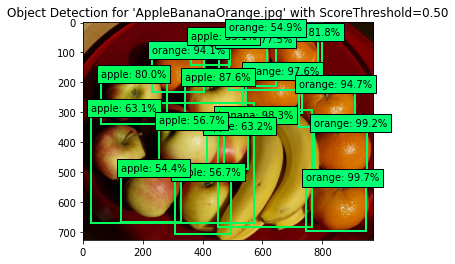

In [5]:
imgFileName = "AppleBananaOrange.jpg"
import cv2
img = np.float32(cv2.imread(imgFileName)) # BGR format
scaledImg, _, _ = CocoDSet.scaleImageAndBoxes(img, None, 512, False)

input = np.float32(scaledImg-CocoDSet.bgrMeans)  # Normalizing the image
dtClasses, dtBoxes, dtScores, dtNum = model.inferOne(input)

print("Number of detected objects: %d"%(dtNum))
for i in range(dtNum):
    cls, box, score = dtClasses[i], dtBoxes[i], dtScores[i]
    print("    %d: %s (%d%%) at %s"%(i,CocoDSet.classNames[int(cls)],int(score*100),str(box)))
    
CocoDSet.showInferResults(img, CocoDSet.p1P2ToP1Size(dtBoxes[:dtNum]),
                          np.int32(dtClasses), dtScores, False,
                          "Object Detection for '%s' with ScoreThreshold=%.2f"%(imgFileName, Model.config.scoreThreshold))

## Evaluating the model
This code runs inference on all images in the COCO test dataset and compares the results with the ground truth information. The evaluation metric usually used for object detection is mean average precision "mAP" which is calculated considering both confidence in detected objects as well as the accuracy of predicted bounding boxes. mAP is the an approximation of the area below precision/recall curve.

In [6]:
# For standard evaluation of the model we need a different set of config:
Model.config.maxDetectionsPerImage = 200
Model.config.maxDetectionPerClass = 100
Model.config.scoreThreshold = 0.01

model = Model.makeFromFile("Models/SSD512.fbm", testDs=testDs, gpus=gpus)
model.initSession()
results = model.evaluate()


Reading from "Models/SSD512.fbm" ... Done.
Creating the fireball model "SSD512" ... Done.
  Processed 5000 Sample. (Time: 78.08 Sec.)                              

Evaluating inference results for 5000 images ... 
  Calculating IoUs - Done (9.9 Seconds)                       
  Finding matches - Done (134.3 Seconds)                     
  Processing the matches - Done (3.7 Seconds)                    
Done (147.9 Seconds)

Average Precision (AP):
    IoU=0.50:0.95   Area: All      MaxDet: 100  = 0.258
    IoU=0.50        Area: All      MaxDet: 100  = 0.476
    IoU=0.75        Area: All      MaxDet: 100  = 0.256
    IoU=0.50:0.95   Area: Small    MaxDet: 100  = 0.102
    IoU=0.50:0.95   Area: Medium   MaxDet: 100  = 0.300
    IoU=0.50:0.95   Area: Large    MaxDet: 100  = 0.379
Average Recall (AR):
    IoU=0.50:0.95   Area: All      MaxDet: 1    = 0.234
    IoU=0.50:0.95   Area: All      MaxDet: 10   = 0.359
    IoU=0.50:0.95   Area: All      MaxDet: 100  = 0.384
    IoU=0.50:0.95   Ar

## Where do I go from here?

[Reducing number of parameters of SSD Model](SSD-Reduce.ipynb)

[Pruning SSD Model](SSD-Prune.ipynb)

[Quantizing SSD Model](SSD-Quantize.ipynb)

[Exporting SSD Model to ONNX](SSD-ONNX.ipynb)

[Exporting SSD Model to CoreML](SSD-CoreML.ipynb)

[Exporting SSD Model to TensorFlow](SSD-TF.ipynb)

---

[Fireball Playgrounds](../Contents.ipynb)

